In [1]:
import torch
import torch.nn as nn
from tqdm import tqdm 
import numpy as np

import seaborn as sns

from densenet import DenseNet3
from dataset import image_dataset

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)


device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
ds_train, ds_val, ds_test = image_dataset()

Loaded datasets from cache.


In [3]:
train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=64, shuffle=True
)  # ,transform=transform?)
val_loader = torch.utils.data.DataLoader(ds_val, batch_size=64, shuffle=True)

model = DenseNet3(
    depth=100,
    num_classes=2,
    growth_rate=12,
    reduction=0.5,
    bottleneck=True,
    dropRate=0.2,
)

print(
    "Number of model parameters: {}".format(
        sum([p.data.nelement() for p in model.parameters()])
    )
)

model = model.to(device)

Number of model parameters: 766418


In [4]:
loss_fn = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters())


def accuracy(output, target):
    pred = output.argmax(dim=1, keepdim=True)  
    correct = pred.eq(target.view_as(pred)).sum().item()
    return correct / output.size(0)

In [5]:
train_losses = []
train_accuracies = []
train_f1 = []
val_losses = []
val_accuracies = []

EPOCHS = 4
for epoch in range(EPOCHS):

    # train
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    train_loader_tqdm = tqdm(
        train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [TRAIN]", unit="batch"
    )
    for i, (ip, target) in enumerate(train_loader_tqdm):
        ip = ip.to(device)
        target = target.to(device)

        out = model(ip)

        loss = loss_fn(out,target)

        prec1 = accuracy(out.data, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * ip.size(0)
        correct_train += accuracy(out, target) * ip.size(0)
        total_train += ip.size(0)

        avg_train_loss = train_loss / total_train
        avg_train_acc = correct_train / total_train
        f1 = f1_score(out.argmax(dim=1).cpu(), target.cpu())
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_acc)
        train_f1.append(f1)
        train_loader_tqdm.set_postfix(
            loss=(train_loss / total_train), acc=(correct_train / total_train),f1=f1
        )

    # eval
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for ip, target in val_loader:
            ip = ip.to(device)
            target = target.to(device)

            out = model(ip)
            loss = loss_fn(out, target)

            val_loss += loss.item() * ip.size(0)
            correct_val += accuracy(out, target) * ip.size(0)
            total_val += ip.size(0)

            avg_val_loss = val_loss / total_val
            avg_val_acc = correct_val / total_val
            val_losses.append(avg_val_loss)
            val_accuracies.append(avg_val_acc)

    print(
        f"Epoch {epoch+1}/{10}, Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}"
    )

Epoch 1/4 [TRAIN]: 100%|██████████| 3434/3434 [12:20<00:00,  4.64batch/s, acc=0.857, f1=0.857, loss=0.334]


Epoch 1/10, Train Loss: 0.3344, Train Acc: 0.8572, Val Loss: 0.5316, Val Acc: 0.7489


Epoch 2/4 [TRAIN]: 100%|██████████| 3434/3434 [12:03<00:00,  4.74batch/s, acc=0.878, f1=1, loss=0.289]    


Epoch 2/10, Train Loss: 0.2888, Train Acc: 0.8781, Val Loss: 0.4000, Val Acc: 0.8313


Epoch 3/4 [TRAIN]: 100%|██████████| 3434/3434 [12:00<00:00,  4.77batch/s, acc=0.886, f1=0.783, loss=0.27] 


Epoch 3/10, Train Loss: 0.2698, Train Acc: 0.8863, Val Loss: 0.4290, Val Acc: 0.8136


Epoch 4/4 [TRAIN]: 100%|██████████| 3434/3434 [12:29<00:00,  4.58batch/s, acc=0.891, f1=0.9, loss=0.257]  


Epoch 4/10, Train Loss: 0.2574, Train Acc: 0.8914, Val Loss: 0.3423, Val Acc: 0.8502


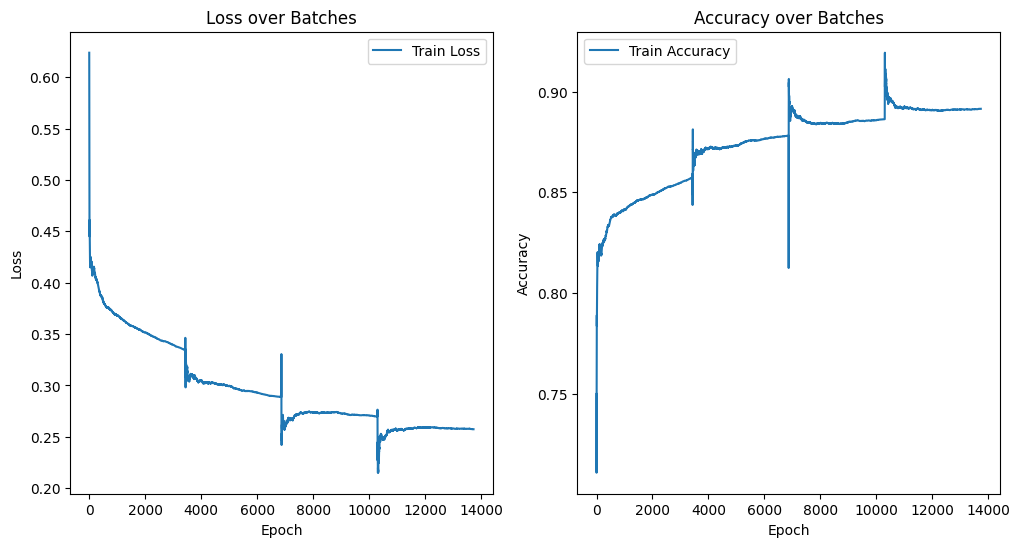

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
#plt.plot(val_losses, label="Validation Loss")
plt.title("Loss over Batches")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
#plt.plot(val_accuracies, label="Validation Accuracy")
plt.title("Accuracy over Batches")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

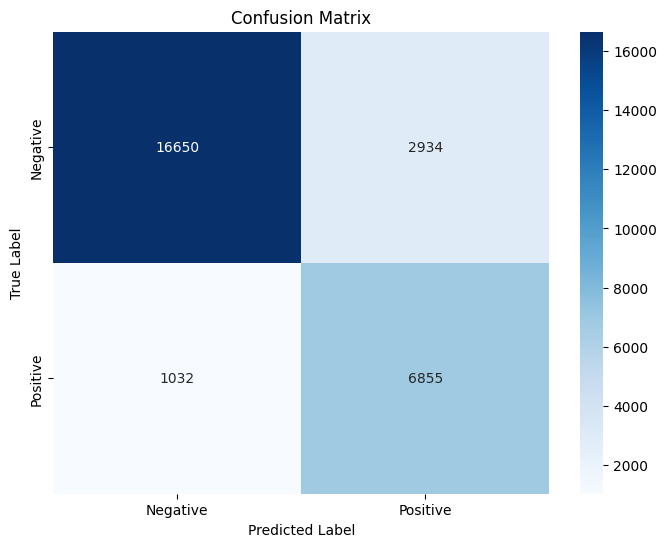

Accuracy: 0.8556
Precision: 0.7003
Recall: 0.8692
F1 Score: 0.7756


In [7]:
test_loader = torch.utils.data.DataLoader(ds_test, batch_size=128, shuffle=True)

import torch
import numpy as np


y_pred = []
y_true = []
model.eval()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        preds = outputs.argmax(dim=1)

        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())


conf_matrix = confusion_matrix(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Negative", "Positive"],
    yticklabels=["Negative", "Positive"],
)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")

In [13]:
from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred, target_names=['Negative','Positive'])


In [15]:
print(report)

              precision    recall  f1-score   support

    Negative       0.93      0.80      0.86     19584
    Positive       0.63      0.86      0.73      7887

    accuracy                           0.82     27471
   macro avg       0.78      0.83      0.80     27471
weighted avg       0.85      0.82      0.82     27471

